In [1]:
import os
import ast
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import KFold
# from keras.wrappers.scikit_learn import KerasClassifier as skKerasClassifier
# from scikeras.wrappers import KerasClassifier

# import keras.api._v2.keras as keras #noqa
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras import activations
# from keras.losses import CategoricalCrossentropy
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
# from keras import regularizers
# import keras.backend as K

from genreclassification.utils import get_project_root

import dataframe_image as dfi
pd.set_option("display.max_columns", None)

2023-01-12 14:32:23.761518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# test best model - retrained on entire training set

---
## data split

In [2]:
df_3 = pd.read_csv(
    get_project_root() / "data/features_3_sec.csv"
)

### features / targets:

In [3]:
# get the target labels:
df_3_y = df_3["label"]

# find the training features:
df_3_x = df_3.drop(
    columns=["filename", "length", "label"]
)

### test split before scaling:

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df_3_x,
    df_3_y,
    test_size=0.2,
    random_state=42
)

In [5]:
for d in [
    (x_train, "x_train"),
    (y_train, "y_train"),
    (x_test, " x_test"),
    (y_test, " y_test")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train: (7992, 57)
y_train: (7992,)
 x_test: (1998, 57)
 y_test: (1998,)


### MinMax scaling for the training set:

In [6]:
scaler = MinMaxScaler((0,1))
# scale fetures and get column names
scale_cols = x_train.columns
x_scaled = scaler.fit_transform(x_train[scale_cols])
# retrieve column names for scaled df:
x_train_scaled = pd.DataFrame(
    x_scaled,
    columns=scale_cols
)

### encoding the categorical classes
* the model will produce a probability score for each of the 10 classes, assigning the most likely label

In [7]:
# start by mapping the labels to numerical values:
catno_to_label = {key:value for (key, value) in enumerate(sorted(set(y_train)))}
# reverse:
label_to_catno = {v:k for k,v in catno_to_label.items()}

In [8]:
y_train = y_train.map(label_to_catno)

label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)

y_train = pd.DataFrame(y_train)

In [9]:
for d in [
    (x_train, "x_train"),
    # (x_val, "  x_val"),
    (y_train, "y_train"),
    # (y_val, "  y_val")
]:
    print(f"{d[1]}: {d[0].shape}")

x_train: (7992, 57)
y_train: (7992, 10)


---

* train NN from here or jump to [testing](#performance-on-test-set) to load a saved model

---
## define model functions ready for gridsearch

#### build:

In [11]:
def build_mlnn(
    hidden_dim=128,
    activation_fn=activations.selu,
    dropout_rate=0.2
):
    model = Sequential(name="mlnn_genre_classification")
    #input layer
    model.add(Dense(
        units=32,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        input_shape=(x_train_scaled.shape[1],),
        name="input")
    )
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden1"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation=activation_fn,
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden2"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # hidden layer
    model.add(Dense(
        units=hidden_dim,
        activation="selu",
        # kernel_regularizer=regularizers.l2(0.01),
        name="hidden3"
    ))
    # batch normalistion:
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(
        units=10,
        activation="softmax",
        name="output"
    ))

    return model

#### compile:

In [12]:
def mlnn_compile(
    model,
    optimiser=optimizers.Adam,
    learning_rate=0.0001
):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimiser(learning_rate=learning_rate),
        metrics=["accuracy"]
    )
    
    return model

#### fit:

* adjust the fit function to monitor loss and not validation loss

In [16]:
def mlnn_fit(
    model,
    x,
    y,
    val_xy=None,
    epochs=700,
    batch_size=32,
):
    history=History()
    
    early_stopping = EarlyStopping(
        monitor="loss",
        min_delta=0,
        restore_best_weights=True,
        patience=epochs,
        baseline=None
    )

    model.fit(
        x,
        y,
        validation_data=val_xy,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[
            history,
            early_stopping
        ]
    )

    return model

## build, compile, fit model on all training data

In [17]:
model = build_mlnn(
    hidden_dim=best["hidden_dim"],
    dropout_rate=best["dropout_rate"]
)

model = mlnn_compile(
    model,
    learning_rate=best["learning_rate"]
)

model = mlnn_fit(
    model,
    x_train_scaled,
    y_train,
    val_xy=None,
    epochs=1300,
    batch_size=best["batch_size"]
)

Epoch 1/1300
250/250 [==============================] - 2s 3ms/step - loss: 1.4222 - accuracy: 0.4975
Epoch 2/1300
250/250 [==============================] - 1s 3ms/step - loss: 1.1456 - accuracy: 0.5953
Epoch 3/1300
250/250 [==============================] - 1s 3ms/step - loss: 1.0276 - accuracy: 0.6369
Epoch 4/1300
250/250 [==============================] - 1s 3ms/step - loss: 0.9615 - accuracy: 0.6655
Epoch 5/1300
250/250 [==============================] - 1s 2ms/step - loss: 0.9481 - accuracy: 0.6692
Epoch 6/1300
250/250 [==============================] - 1s 2ms/step - loss: 0.9074 - accuracy: 0.6814
Epoch 7/1300
250/250 [==============================] - 1s 2ms/step - loss: 0.8625 - accuracy: 0.6944
Epoch 8/1300
250/250 [==============================] - 1s 3ms/step - loss: 0.8435 - accuracy: 0.7027
Epoch 9/1300
250/250 [==============================] - 1s 2ms/step - loss: 0.8249 - accuracy: 0.7111
Epoch 10/1300
250/250 [==============================] - 1s 2ms/step - loss: 0.799

### save model:

In [18]:
model.save(
    get_project_root() / "models/best_mlnn_all_training/best_mlnn_all_training"
)

INFO:tensorflow:Assets written to: /Users/djq98242/repos/genre_classification/models/best_mlnn_all_training/best_mlnn_all_training/assets


---
## performance on test set

### best parameters:

In [10]:
gs_results = pd.read_pickle(
    get_project_root() / "output/gs_results_20221217.pkl"
)

best = gs_results[gs_results["accuracy"] == gs_results["accuracy"].max()]
best = best["params"].reset_index(drop=True)[0]
best = ast.literal_eval(best)

In [12]:
best

{'hidden_dim': 128,
 'dropout_rate': 0.1,
 'learning_rate': 0.001,
 'batch_size': 32}

### load model:

In [13]:
model = load_model(
    get_project_root() / "models/best_mlnn_all_training/best_mlnn_all_training"
)

2023-01-12 14:33:30.584728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "mlnn_genre_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 32)                1856      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 hidden1 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128) 

### prediction

In [15]:
# scale the x_test with the same scaler as used on the training set:
scale_cols = x_test.columns
x_test_scaled = scaler.transform(x_test[scale_cols])
# retrieve column names for scaled df:
x_test_scaled = pd.DataFrame(
    x_test_scaled,
    columns=scale_cols
)

* would be good practice to code this into a pipeline

In [16]:
pred = model.predict(x_test_scaled)

63/63 [==============================] - 0s 2ms/step


In [17]:
pred_class = np.argmax(pred, axis=1)
pred_class = pd.Series(pred_class)
# pred_class

In [18]:
pred_class = pred_class.map(catno_to_label)

In [19]:
y_test.reset_index(drop=True, inplace=True)

In [20]:
cm = confusion_matrix(
    y_test,
    pred_class
)
cm

array([[197,   0,   4,   1,   0,   3,   0,   0,   1,   2],
       [  0, 199,   0,   0,   0,   4,   0,   0,   0,   0],
       [  0,   2, 178,   0,   0,   3,   0,   2,   1,   0],
       [  1,   4,   1, 191,   1,   0,   0,   0,   0,   1],
       [  1,   0,   1,   2, 209,   0,   0,   2,   2,   1],
       [  1,   3,   0,   0,   0, 188,   0,   0,   0,   0],
       [  2,   0,   2,   0,   0,   0, 197,   0,   0,   3],
       [  0,   1,   0,   1,   1,   2,   0, 171,   3,   1],
       [  0,   1,   2,   2,   4,   0,   0,   0, 201,   1],
       [  2,   1,   1,   1,   1,   0,   3,   1,   1, 186]])

In [21]:
ConfusionMatrixDisplay(
    cm,
    display_labels=label_to_catno.keys()
)

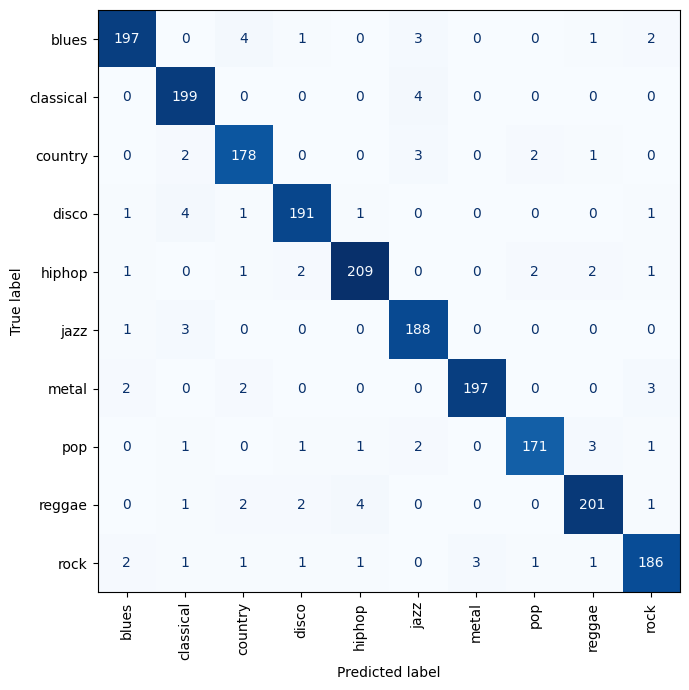

In [22]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay(
    cm,
    display_labels=label_to_catno.keys()
).plot(
    xticks_rotation=90,
    cmap="Blues",
    colorbar=False,
    ax=ax
)
fig.tight_layout()

In [23]:
fig.savefig(
    get_project_root() / "output/mlnn/best_mlnn_all_training_cm.svg"
)
fig.savefig(
    get_project_root() / "output/mlnn/best_mlnn_all_training_cm.png"
)

In [24]:
def average_metrics(y_test, y_pred):
    scorers = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_micro": f1_score(y_test, y_pred, average="micro"),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "recall_micro": recall_score(y_test, y_pred, average="micro"),
        "recall_macro": recall_score(y_test, y_pred, average="macro"),
        "precision_micro": precision_score(y_test, y_pred, average="micro"),
        "precision_macro": precision_score(y_test, y_pred, average="macro")
    }
    df = pd.DataFrame(index=scorers.keys(), columns=["metric score"])
    for scorer in scorers.keys():
        df.at[scorer, "metric score"] = scorers[scorer]
    df=df.transpose()
    return df

def class_metrics(y_test, y_pred, class_labels):
    df = pd.DataFrame(index=list(class_labels))

    for scorer in [
        ("recall", recall_score),
        ("precision", precision_score),
        ("f1", f1_score)
    ]:
        metric_score = scorer[1](
            y_test,
            y_pred,
            average=None,
            labels=list(class_labels)
        )
        df[scorer[0]] = metric_score

    df = df.transpose()

    return df

In [25]:
av_metrics = average_metrics(y_test, pred_class)
av_metrics

,accuracy,f1_micro,f1_macro,recall_micro,recall_macro,precision_micro,precision_macro
metric score,0.959459,0.959459,0.959357,0.959459,0.959454,0.959459,0.959501


In [26]:
dfi.export(
    av_metrics,
    "../output/mlnn/best_mlnn_all_training_average_metrics.png"
)

[0112/143402.479401:INFO:headless_shell.cc(223)] 19822 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmplw0od0ga/temp.png


In [27]:
av_metrics_t = av_metrics.transpose()
dfi.export(
    av_metrics_t,
    "../output/mlnn/best_mlnn_all_training_average_metrics_t.png"
)

[0112/143405.414898:INFO:headless_shell.cc(223)] 31214 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmp50jebumw/temp.png


In [28]:
c_metrics = class_metrics(y_test, pred_class, label_to_catno.keys())
c_metrics

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
recall,0.947115,0.980296,0.956989,0.959799,0.958716,0.979167,0.965686,0.950000,0.952607,0.944162
precision,0.965686,0.943128,0.941799,0.964646,0.967593,0.940000,0.985000,0.971591,0.961722,0.953846
f1,0.956311,0.961353,0.949333,0.962217,0.963134,0.959184,0.975248,0.960674,0.957143,0.948980


In [29]:
dfi.export(
    c_metrics,
    "../output/mlnn/best_mlnn_all_training_class_metrics.png"
)

[0112/143419.427153:INFO:headless_shell.cc(223)] 39766 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmpxf78a8rw/temp.png


In [30]:
c_metrics_t = c_metrics.transpose()
dfi.export(
    c_metrics_t,
    "../output/mlnn/best_mlnn_all_training_class_metrics_t.png"
)

[0112/143422.626571:INFO:headless_shell.cc(223)] 57549 bytes written to file /var/folders/ng/4x8hyf_s39b2rqzs184hl_lr0000gp/T/tmp6uzxsk7d/temp.png


---

In [33]:
model.get_config()

{'name': 'mlnn_genre_classification',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 57),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'input',
    'trainable': True,
    'batch_input_shape': (None, 57),
    'dtype': 'float32',
    'units': 32,
    'activation': 'selu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_4',
    'trainable': True,
    'dtype': 'float32',
    'axis': ListWrapper([1]),
    'momentum': 0.99,
    'epsilon': 0.001,
    'center': True,
    'scale': True,
    'beta_initia

In [34]:
model._get_compile_args()

{'optimizer': <keras.optimizers.optimizer_v2.adam.Adam at 0x15af86e80>,
 'loss': <function keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)>,
 'metrics': [[<keras.metrics.base_metric.MeanMetricWrapper at 0x15afa2b50>]],
 'weighted_metrics': None,
 'loss_weights': None}